This file needs requires external data!

(Run on workstation)

In [9]:
import xarray as xr
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean as cmo

import sys

sys.path.append('../src')
import utils as ut
import warnings
warnings.filterwarnings("ignore")

In [10]:
#Get time-independent variables
ds = xr.open_dataset('../data/ecefiles/areas.nc')
area = ds['O1t0.srf'].values;
ds.close()

fnames = sorted(glob.glob(f'../data/ecefiles/n011/n011*.nc'))

ds = xr.open_dataset(fnames[0])
lat = ds['nav_lat'].values
lon = ds['nav_lon'].values
levmid = ds['olevel'].values
lev = ds['olevel_bounds'].values
time_bnds = ds['time_centered_bounds']
thick = ds['e3t'].values #Quasi-time-independent, treated as fixed


ds.close()
secs = (time_bnds[:12,1]-time_bnds[:12,0]).values / np.timedelta64(1, 's')

months = np.arange(0,12)

In [16]:
def get_section(run,var,t0,t1,verbose=True):

    assert var in ['thetao','so']
    
    jmax = 45
    
    Vall = np.zeros((len(ut.basin),len(levmid),jmax))  
    
    lons = np.repeat(lon[np.newaxis,:jmax,:],len(levmid),axis=0)
    lats = np.repeat(lat[np.newaxis,:jmax,:],len(levmid),axis=0)
    mask = np.repeat(np.zeros(lons.shape)[np.newaxis,:,:,:],len(ut.basin),axis=0)
    
    zz = np.zeros(len(ut.basin))
    
    for b,bas in enumerate(ut.basin):
        mm = np.nan*np.zeros(lons.shape)
        if bas=='East Ant.':
            #EAIS
            mm[((lons<173) & (lons>-10)) & (lats<-65) & (lats>-76)] = 1
            zz[b] = 369
        if bas=='Ross':
            #ROSS
            mm[((lons>150) | (lons<-150)) & (lats<-76)] = 1
            zz[b] = 312        
        if bas=='Amundsen':
            #AMUN
            mm[(lons>-150) & (lons<-80) & (lats<-70)] = 1
            zz[b] = 305
        if bas=='Weddell':
            #WEDD
            mm[(lons>-65) & (lons<-10) & (lats<-72)] = 1
            zz[b] = 420
        if bas=='Peninsula':
            #APEN
            mm[(lons>-66) & (lons<-56) & (lats>-70) & (lats<-65)] = 1
            mm[(lons>-80) & (lons<-65) & (lats>-75) & (lats<-70)] = 1
            zz[b] = 420
        mask[b,:,:,:] = mm
    
    if run=='n011':
        tt0 = t0+100
        tt1 = t1+100
    else:
        tt0 = t0
        tt1 = t1

    if run=='piControl':
        fnames = sorted(glob.glob(f'../data/ecefiles/cmip6/{var}_Omon_EC-Earth3_{run}*.nc'))
        nyears = len(fnames)
    else:    
        fnames = sorted(glob.glob(f'../data/ecefiles/{run}/{run}*T.nc'))
        nyears = 0
        for fname in fnames:
            ds = xr.open_dataset(fname)
            nyears += int(np.floor(len(ds.time_counter)/12))
            ds.close()
    assert nyears >= tt1,f'Time series too short, reduce t1'

    V = np.zeros((nyears,len(ut.basin),len(levmid),jmax))
    
    if verbose: print('Getting',var,'from',run)
    c = -1
    for f,fname in enumerate(fnames):
        if c >= tt1:
            #print(year0+y,c,run,'finished')
            break
        ds = xr.open_dataset(fname)
        
        if run=='piControl':
            time = ds['time'].values
            year0 = int(fname[-16:-12])
        else:
            time = ds['time_centered'].values 
            year0 = int(fname[-27:-23])

        ny = int(len(time)/12)
        if c+ny<tt0:
            c += ny
            #print(year0,c,'skipping file')
            continue

        if run=='piControl':
            ds = ds.sel(j=slice(0,jmax))
            lat0 = ds['latitude'].mean(dim='i').values
        else:
            ds = ds.sel(y=slice(0,jmax))
            lat0 = ds['nav_lat'].mean(dim='x').values
            
        varb = ds[var]
        ds.close()

        for y in np.arange(0,ny):
            c += 1
            if c<tt0:
                #print(year0+y,c,'skipping year')
                continue            
            if c >= tt1:
                #print(year0+y,c,'got all years')
                break
            vb = np.zeros((len(levmid),jmax,lon.shape[1]))
            for m,mm in enumerate(months):
                vbb = varb[m+12*y,:,:,:]
                vb += vbb*secs[m]
            for b,bas in enumerate(ut.basin):
                V[c,b,:,:] = np.nanmean(vb/sum(secs)*mask[b,:,:,:],axis=-1)
            if verbose: print('Got year',year0+y)

    Vall[:,:,:] = V[tt0:tt1,:,:,:].mean(axis=0)
    if verbose: print('-------------')
    return Vall,lat0,zz

In [17]:
def plot_TS_anom(plotvars,cmaps,vmin,vmax,ylabels,lat0,zz,title=None,savename=None,showplot=True):

    mpl.rcParams['figure.subplot.top'] = .9
    
    fig,ax = plt.subplots(len(plotvars),len(ut.basin),sharex=True,sharey=True)

    for b,bas in enumerate(ut.basin):
        
        for v,vv in enumerate(plotvars):
            cmapp = plt.get_cmap(cmaps[v]).copy()
            cmapp.set_bad('.8')

            im = ax[v,b].pcolormesh(lat0,-levmid,vv[b,:,:],shading='nearest',cmap=cmapp,vmin=vmin[v],vmax=vmax[v])
            if b==4:
                plt.colorbar(im,ax=ax[v,b],extend='both')
            ax[v,b].fill_between(lat0,lat0*0-zz[b]-50,lat0*0-zz[b]+50,color=ut.bcol[bas],alpha=.2)
            if b==0:
                ax[v,b].set_ylabel(ylabels[v])
    
        ax[0,b].set_title(bas,c=ut.bcol[bas])

    ax[0,0].set_ylim([-750,0])
    ax[0,0].set_xticks([-75,-70,-65])
    ax[0,0].set_xticklabels(['75','70','65'])  
    ax[-1,2].set_xlabel('Latitude [deg S]')
    fig.suptitle(title)
    #fig.supylabel('Depth [m]')

    if savename is not None:
        plt.savefig(savename,dpi=450)
        print(f'Saved {savename}')
    if showplot: plt.show()

In [18]:
T0c,lat0,zz = get_section('piControl','thetao',0,500)
T1c,lat0,zz = get_section('n011','thetao',0,150)

Getting thetao from piControl
Got year 2259
Got year 2260
Got year 2261


KeyboardInterrupt: 

In [ ]:
plotvars = [T0c,T1c,T1c-T0c]
cmaps = np.array(['cmo.thermal','cmo.thermal','cmo.balance'])
vmin = np.array([-2,-2,-2])
vmax = np.array([3,3,2])
ylabels = ['piControl','CTRL','CTRL-piControl']
    
plot_TS_anom(plotvars,cmaps,vmin,vmax,ylabels,lat0,zz,savename=f'../draftfigs/sections.png')

In [ ]:
cmaps = np.array(['cmo.thermal','cmo.balance','cmo.haline','cmo.tarn_r'])
vmin = np.array([-2,-1,33,-1])
vmax = np.array([3,1,35,1])
ylabels = ['T CTRL','T TOTL-CTRL','S CTRL','S TOTL-CTRL']
verbose = False

tmax = 11
run = 'half'

for t0 in range(0,tmax):
    T0,lat0,zz = get_section('n011','thetao',t0,t0+1,verbose=verbose)
    T1,lat0,zz = get_section(run,'thetao',t0,t0+1,verbose=verbose)
    S0,lat0,zz = get_section('n011','so',t0,t0+1,verbose=verbose)
    S1,lat0,zz = get_section(run,'so',t0,t0+1,verbose=verbose)  
    plotvars = [T0,T1-T0,S0,S1-S0]
    plot_TS_anom(plotvars,cmaps,vmin,vmax,ylabels,lat0,zz,title=f'Year {t0} of {tmax}',savename=f'../videos/sections_{run}_{t0:03.0f}.png')

Saved ../videos/sections_quar_000.png


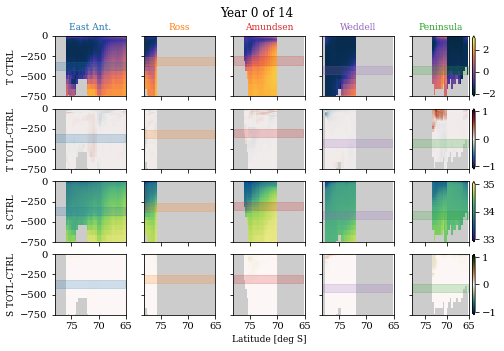

Saved ../videos/sections_quar_001.png


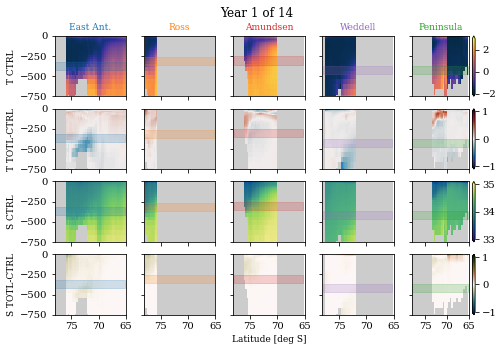

Saved ../videos/sections_quar_002.png


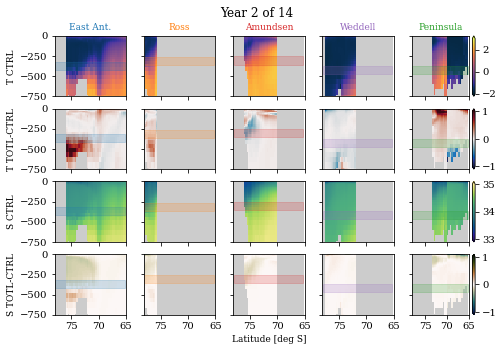

Saved ../videos/sections_quar_003.png


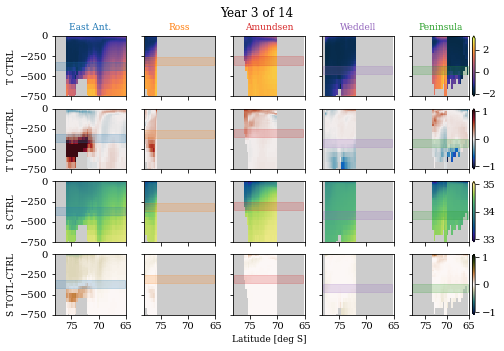

Saved ../videos/sections_quar_004.png


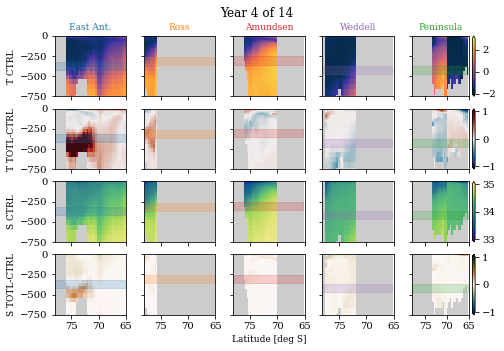

Saved ../videos/sections_quar_005.png


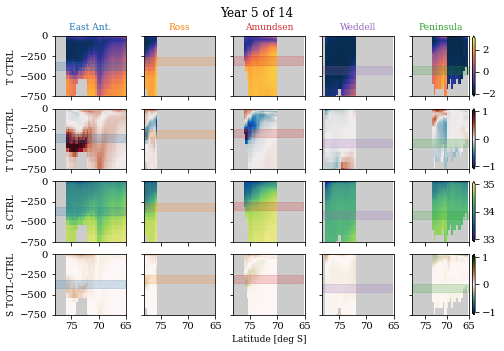

Saved ../videos/sections_quar_006.png


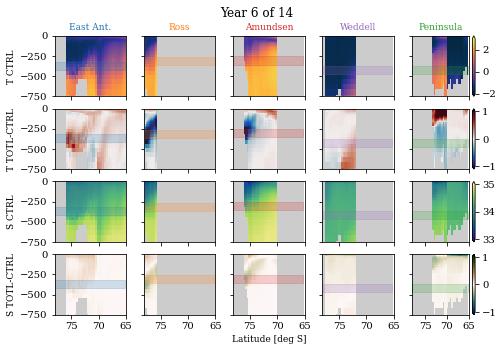

Saved ../videos/sections_quar_007.png


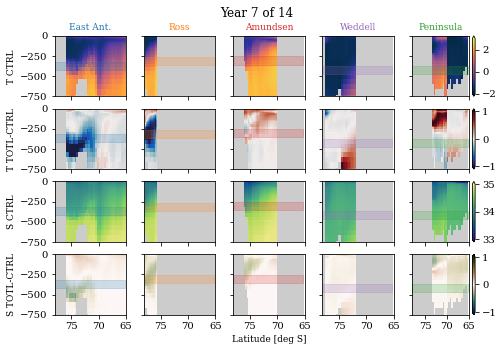

Saved ../videos/sections_quar_008.png


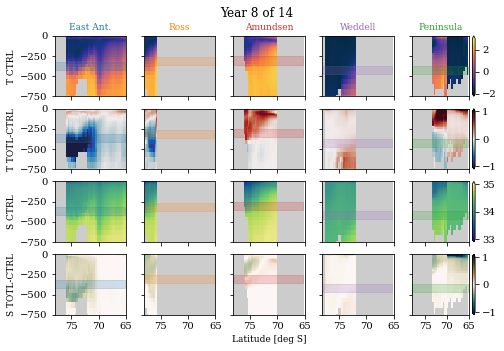

Saved ../videos/sections_quar_009.png


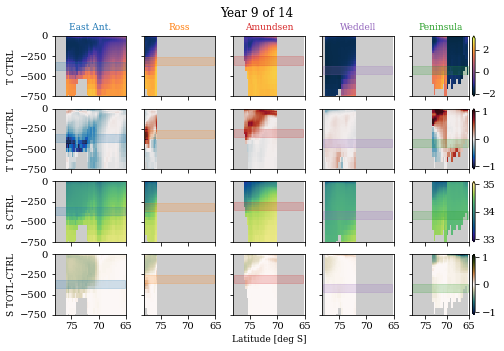

Saved ../videos/sections_quar_010.png


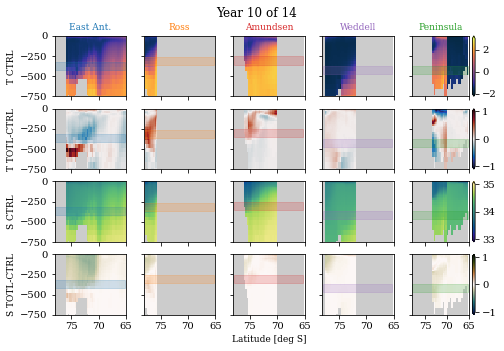

Saved ../videos/sections_quar_011.png


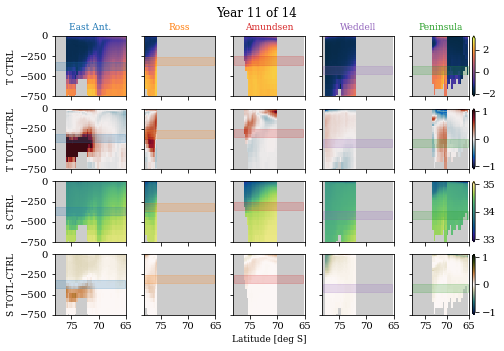

Saved ../videos/sections_quar_012.png


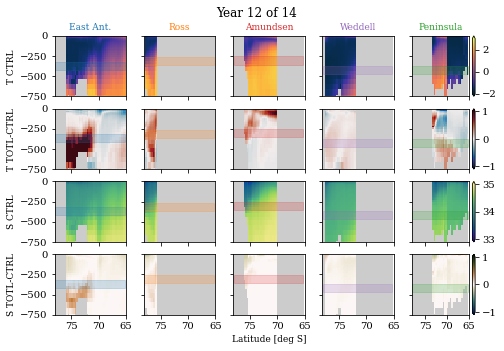

Saved ../videos/sections_quar_013.png


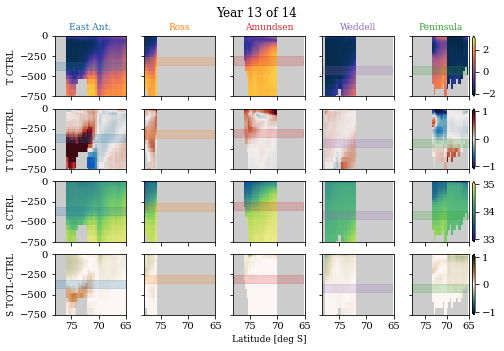

In [20]:
cmaps = np.array(['cmo.thermal','cmo.balance','cmo.haline','cmo.tarn_r'])
vmin = np.array([-2,-1,33,-1])
vmax = np.array([3,1,35,1])
ylabels = ['T CTRL','T TOTL-CTRL','S CTRL','S TOTL-CTRL']
verbose = False

tmax = 14
run = 'quar'

for t0 in range(0,tmax):
    T0,lat0,zz = get_section('n011','thetao',t0,t0+1,verbose=verbose)
    T1,lat0,zz = get_section(run,'thetao',t0,t0+1,verbose=verbose)
    S0,lat0,zz = get_section('n011','so',t0,t0+1,verbose=verbose)
    S1,lat0,zz = get_section(run,'so',t0,t0+1,verbose=verbose)  
    plotvars = [T0,T1-T0,S0,S1-S0]
    plot_TS_anom(plotvars,cmaps,vmin,vmax,ylabels,lat0,zz,title=f'Year {t0} of {tmax}',savename=f'../videos/sections_{run}_{t0:03.0f}.png')

In [ ]:

cmaps = np.array(['cmo.thermal','cmo.thermal','cmo.balance'])
vmin = np.array([-2,-2,-2])
vmax = np.array([3,3,2])
ylabels = ['piControl','CTRL','CTRL-piControl']
verbose = False

tmax = 300

for t0 in range(0,tmax):
    T1cc,lat0,zz = get_section('n011','thetao',t0-100,t0-100+1,verbose=verbose)
    plotvars = [T0c,T1cc,T1cc-T0c]
    plot_TS_anom(plotvars,cmaps,vmin,vmax,ylabels,lat0,zz,title=f'Year {t0} of {tmax}',savename=f'../videos/sections_ctrl_{t0:03.0f}.png',showplot=False)